In [1]:
# Uncomment if you need to install:
# !pip install pymysql sqlalchemy pandas python-dotenv pandoc

In [2]:
from Utils import setup_database_connection, load_data
from Utils import load_all_players
from Utils import COLOUR_BANNED, COLOUR_NON_BANNED, COLOUR_BLUE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

player_data = load_data('data.csv')

Connecting to database...
Connection successful!
Loaded 302207 players


In [3]:
print(f"Columns ({len(player_data.columns)}):")
for i, col in enumerate(player_data.columns, 1):
    print(f"\t{i:2}. {col}")

player_data.head()

Columns (37):
	 1. steam_id
	 2. accuracy_enemy_spotted
	 3. accuracy_head
	 4. counter_strafing_good_shots_ratio
	 5. created_at
	 6. ct_opening_aggression_success_rate
	 7. ct_opening_duel_success_percentage
	 8. flashbang_hit_foe_avg_duration
	 9. flashbang_hit_foe_per_flashbang
	10. flashbang_hit_friend_per_flashbang
	11. flashbang_leading_to_kill
	12. flashbang_thrown
	13. has_ban
	14. he_foes_damage_avg
	15. he_friends_damage_avg
	16. name
	17. preaim
	18. rank_faceit_elo
	19. rank_premier
	20. rating_aim
	21. rating_clutch
	22. rating_ct_leetify
	23. rating_opening
	24. rating_positioning
	25. rating_t_leetify
	26. rating_utility
	27. reaction_time_ms
	28. spray_accuracy
	29. t_opening_aggression_success_rate
	30. t_opening_duel_success_percentage
	31. total_matches
	32. trade_kill_opportunities_per_round
	33. trade_kills_success_percentage
	34. traded_deaths_success_percentage
	35. updated_at
	36. utility_on_death_avg
	37. win_rate


,steam_id,accuracy_enemy_spotted,accuracy_head,counter_strafing_good_shots_ratio,created_at,ct_opening_aggression_success_rate,ct_opening_duel_success_percentage,flashbang_hit_foe_avg_duration,flashbang_hit_foe_per_flashbang,flashbang_hit_friend_per_flashbang,...,spray_accuracy,t_opening_aggression_success_rate,t_opening_duel_success_percentage,total_matches,trade_kill_opportunities_per_round,trade_kills_success_percentage,traded_deaths_success_percentage,updated_at,utility_on_death_avg,win_rate
0,76561197960265861,32.2254,22.5629,73.3536,2025-11-02 21:31:39.509392,47.9923,53.6181,2.9302,0.7763,0.4125,...,35.1063,17.1551,20.2323,5307,0.3146,53.2647,50.8498,2025-11-02 21:31:39.509394,206.7068,0.4483
1,76561197960265876,35.9335,25.7890,84.6939,2025-11-06 04:59:37.682057,51.8211,58.5152,2.9077,0.7765,0.2791,...,38.9122,31.4580,38.3908,3620,0.3185,50.7620,50.5668,2025-11-06 04:59:37.682059,248.4293,0.5862
2,76561197960266237,35.5472,13.8768,71.1351,2025-11-04 14:38:07.114329,55.5724,66.6675,2.3559,0.5507,0.3734,...,37.9746,44.5501,47.3604,662,0.3123,44.7388,55.3971,2025-11-04 14:38:07.114331,326.4985,0.5862
3,76561197960266426,33.8673,19.1540,73.0331,2025-11-08 09:45:35.609648,23.5341,30.0317,3.0118,0.6969,0.3825,...,40.8443,21.8039,31.3789,800,0.3627,45.7713,47.8039,2025-11-08 09:45:35.609649,169.4849,0.5172
4,76561197960266881,35.8562,21.0954,79.5196,2025-11-03 12:00:20.302366,33.8234,35.1713,2.8077,0.7619,0.1791,...,39.1881,24.9387,25.9190,1491,0.3429,42.3080,47.9965,2025-11-03 12:00:20.302368,394.1489,0.7333


## Target Feature and Class Balance Analysis

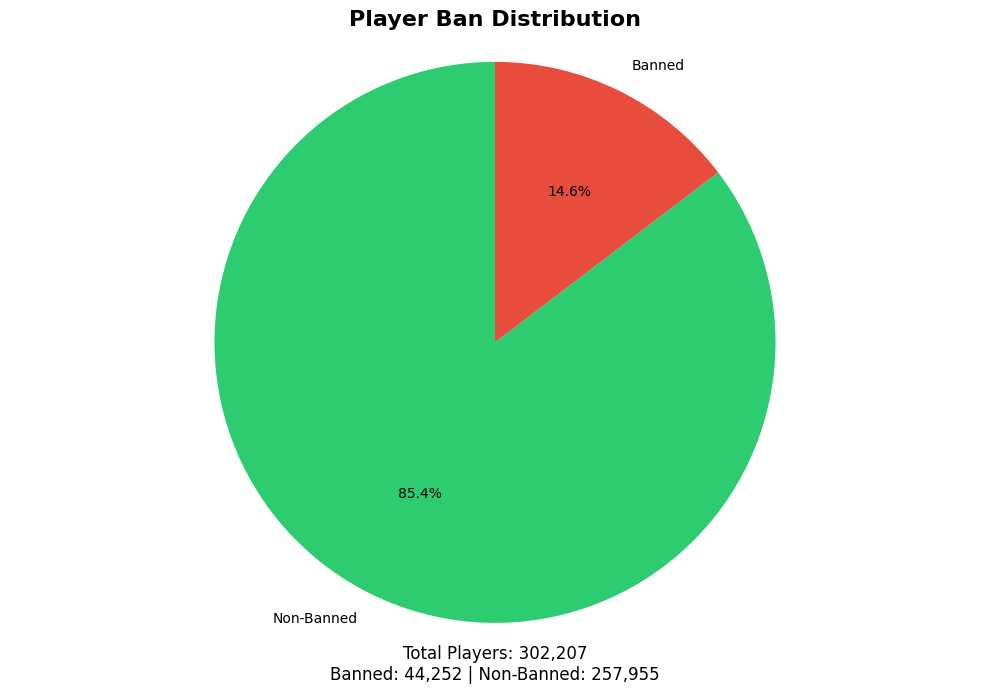

In [4]:
ban_counts = player_data['has_ban'].value_counts()
labels = ['Non-Banned', 'Banned']
false, true = b'\x00', b'\x01'
sizes = [ban_counts.get(false, 0), ban_counts.get(true, 0)]
colors = [COLOUR_NON_BANNED, COLOUR_BANNED]

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels,  colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Player Ban Distribution', fontsize=16, weight='bold')

total = sum(sizes)
plt.text(0, -1.2, f'Total Players: {total:,}\nBanned: {sizes[1]:,} | Non-Banned: {sizes[0]:,}'
         ,ha='center', fontsize=12)

plt.axis('equal')
plt.tight_layout()
plt.show()

### Results:
Before processing, approximately 1/4 of the our dataset are banned players. Some weighting towards banned players will be required

## Data Quality Checks

In [5]:
# Checks if any columns are missing values
missing_counts = player_data.isnull().sum()
missing_percent = (missing_counts / len(player_data)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_percent.values
})

missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print(missing_df.to_string(index=False))


Column  Missing Count  Missing %
  name              8   0.002647


In [6]:
# Checks for duplicate entries
duplicate_steam_ids = player_data['steam_id'].duplicated().sum()
print(f"Duplicate Steam Id's: {duplicate_steam_ids:,}")

duplicate_rows = player_data.duplicated().sum()
print(f"Fully duplicate rows: {duplicate_rows:,}")

if duplicate_steam_ids > 0:
    print("Duplicates found")

Duplicate Steam Id's: 0
Fully duplicate rows: 0


### Results:
No missing values or duplicate entries were found in the dataset. (we can ignore the name column)

## Mean Comparison: Banned vs Non-Banned Players

In [7]:
df_banned = player_data[player_data['has_ban'] == true]
df_non_banned = player_data[player_data['has_ban'] == false]

numeric_cols = player_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
excluded_cols = ['steam_id', 'created_at', 'updated_at', 'rank_premier', 'rank_faceit_elo' ,'total_matches']
numeric_cols = [col for col in numeric_cols if col not in excluded_cols]

banned_means = df_banned[numeric_cols].mean()
non_banned_means = df_non_banned[numeric_cols].mean()

difference = banned_means - non_banned_means
pct_difference = ((banned_means - non_banned_means) / non_banned_means * 100).fillna(0)

comparison_df = pd.DataFrame({
    'Feature': numeric_cols,
    'Non-Banned Mean': non_banned_means.values,
    'Banned Mean': banned_means.values,
    'Difference': difference.values,
    'Difference %': pct_difference.values
})

# Sort by absolute percentage difference to see most discriminative features
comparison_df['Abs Difference %'] = comparison_df['Difference %'].abs()
comparison_df = comparison_df.sort_values('Abs Difference %', ascending=False)
comparison_df = comparison_df.drop('Abs Difference %', axis=1)

print(comparison_df.to_string(index=False))

                           Feature  Non-Banned Mean  Banned Mean  Difference  Difference %
                    rating_opening        -0.001874     0.001160    0.003034   -161.864166
                     rating_clutch         0.106698     0.027308   -0.079390    -74.406519
 t_opening_aggression_success_rate        33.612662    17.092776  -16.519886    -49.147805
  traded_deaths_success_percentage        49.110645    26.817409  -22.293236    -45.393897
             he_friends_damage_avg         0.512402     0.740941    0.228540     44.601683
                rating_positioning        49.710911    28.250502  -21.460409    -43.170420
trade_kill_opportunities_per_round         0.293863     0.167566   -0.126297    -42.978200
    trade_kills_success_percentage        43.201003    25.416841  -17.784161    -41.166084
ct_opening_duel_success_percentage        44.555419    26.272336  -18.283083    -41.034477
 t_opening_duel_success_percentage        40.314389    24.619783  -15.694606    -38.930531

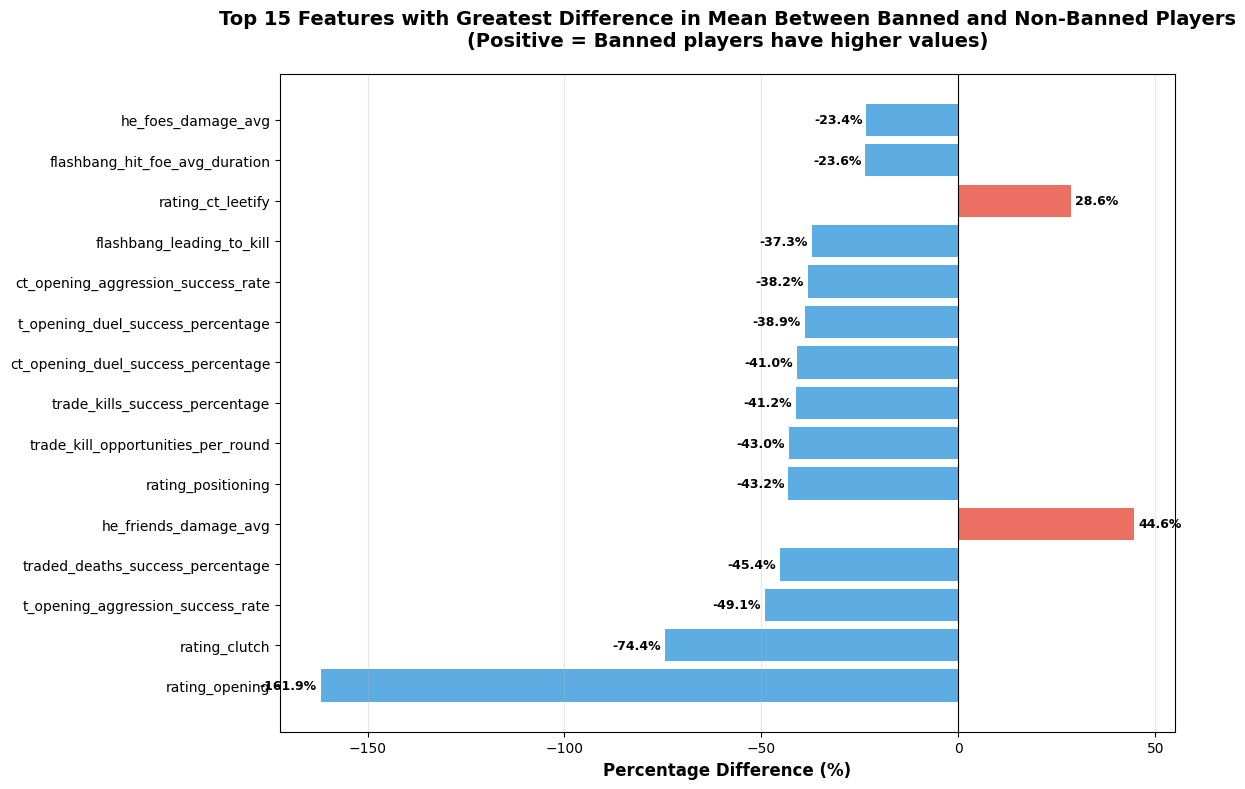

In [8]:

top_features = comparison_df.head(15).copy()

fig, ax = plt.subplots(figsize=(12, 8))

colors = [COLOUR_BANNED if x > 0 else COLOUR_BLUE for x in top_features['Difference %']]
bars = ax.barh(range(len(top_features)), top_features['Difference %'],  color= colors, alpha=0.8)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=10)
ax.set_xlabel('Percentage Difference (%)', fontsize=12, weight='bold')
ax.set_title(f'Top 15 Features with Greatest Difference in Mean Between Banned and Non-Banned Players\n(Positive = Banned players have higher values)',
             fontsize=14, weight='bold', pad=20)
ax.axvline(x=0,  color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, top_features['Difference %'])):
    ax.text(val + (1 if val > 0 else -1), i, f'{val:.1f}%', 
            va='center', ha='left' if val > 0 else 'right', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

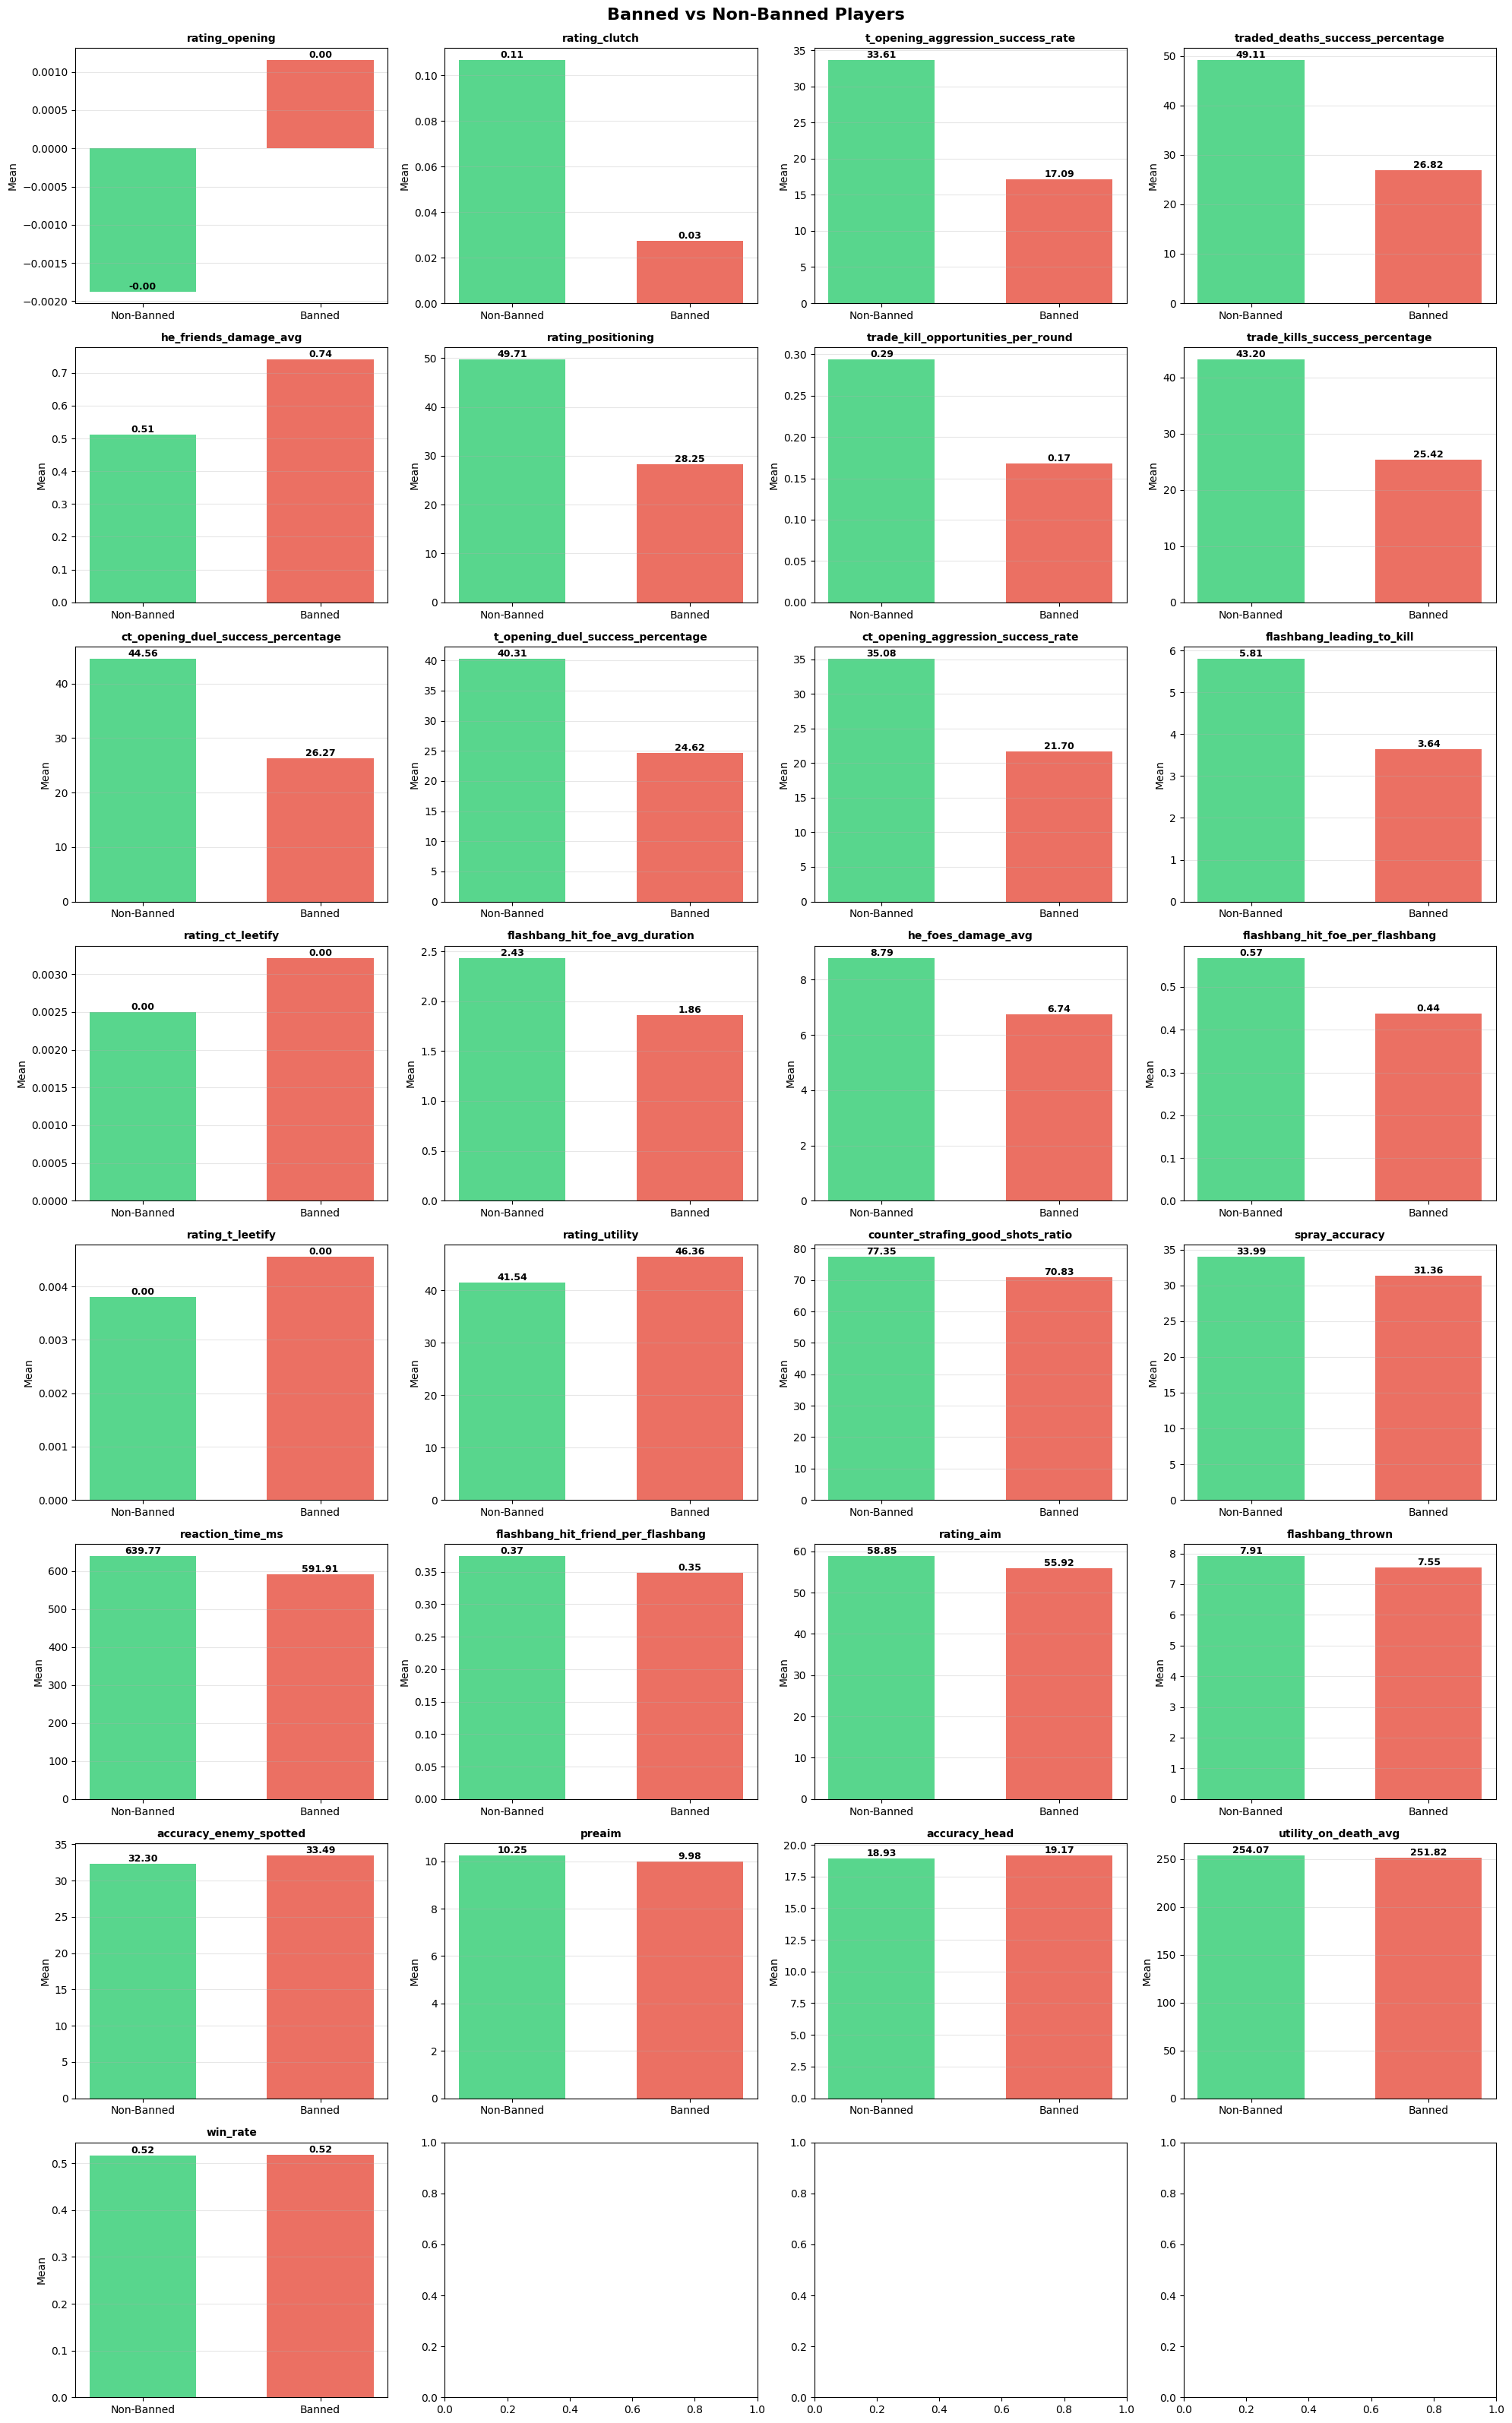

In [9]:
features = comparison_df['Feature'].tolist()

n_features = len(features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    
    non_banned_mean = comparison_df[comparison_df['Feature'] == feature]['Non-Banned Mean'].values[0]
    banned_mean = comparison_df[comparison_df['Feature'] == feature]['Banned Mean'].values[0]
    
    bars = ax.bar(['Non-Banned', 'Banned'], [non_banned_mean, banned_mean],
                   color=[COLOUR_NON_BANNED, COLOUR_BANNED], alpha=0.8, width=0.6)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, weight='bold')
    
    ax.set_title(feature, fontsize=10, weight='bold')
    ax.set_ylabel('Mean', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

plt.suptitle('Banned vs Non-Banned Players',
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Results:
For some reason, banned players have significantly worse mean performance across nearly all features, opposite to what we would expect. Requires further investigation.

## Distribution Analysis: Opening Duel Success

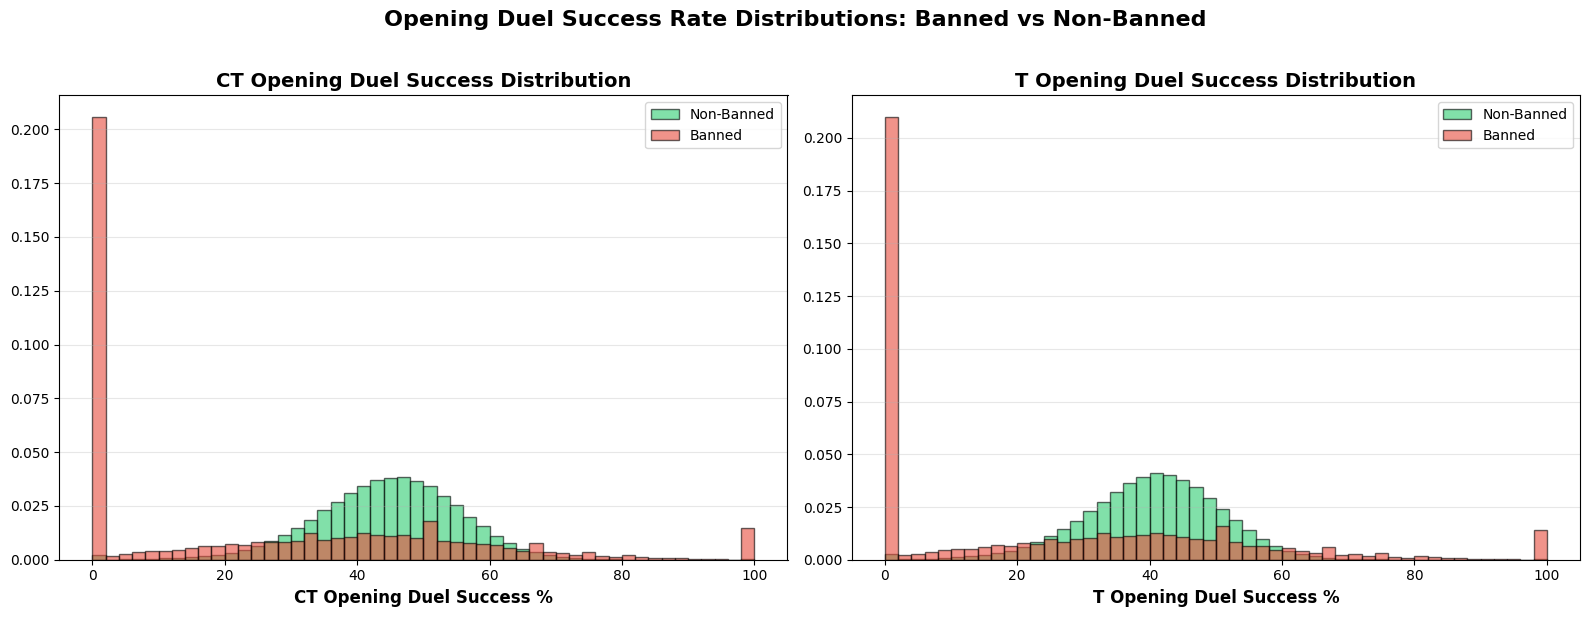

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
ax1.hist(df_non_banned['ct_opening_duel_success_percentage'].dropna(),
         bins=50, alpha=0.6,  color=COLOUR_NON_BANNED, label='Non-Banned', density=True, edgecolor='black')
ax1.hist(df_banned['ct_opening_duel_success_percentage'].dropna(),
         bins=50, alpha=0.6,  color=COLOUR_BANNED, label='Banned', density=True, edgecolor='black')
ax1.set_xlabel('CT Opening Duel Success %', fontsize=12, weight='bold')
ax1.set_title('CT Opening Duel Success Distribution', fontsize=14, weight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# T Opening Duel Success
ax2 = axes[1]
ax2.hist(df_non_banned['t_opening_duel_success_percentage'].dropna(),
         bins=50, alpha=0.6,  color=COLOUR_NON_BANNED, label='Non-Banned', density=True, edgecolor='black')
ax2.hist(df_banned['t_opening_duel_success_percentage'].dropna(),
         bins=50, alpha=0.6,  color=COLOUR_BANNED, label='Banned', density=True, edgecolor='black')
ax2.set_xlabel('T Opening Duel Success %', fontsize=12, weight='bold')
ax2.set_title('T Opening Duel Success Distribution', fontsize=14, weight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Opening Duel Success Rate Distributions: Banned vs Non-Banned', 
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Results:
Banned players have extremely high amount of entries with 0 values for these 2 features, if this is the same for most other features then this is likely the reason the means tended to be much lower than expected

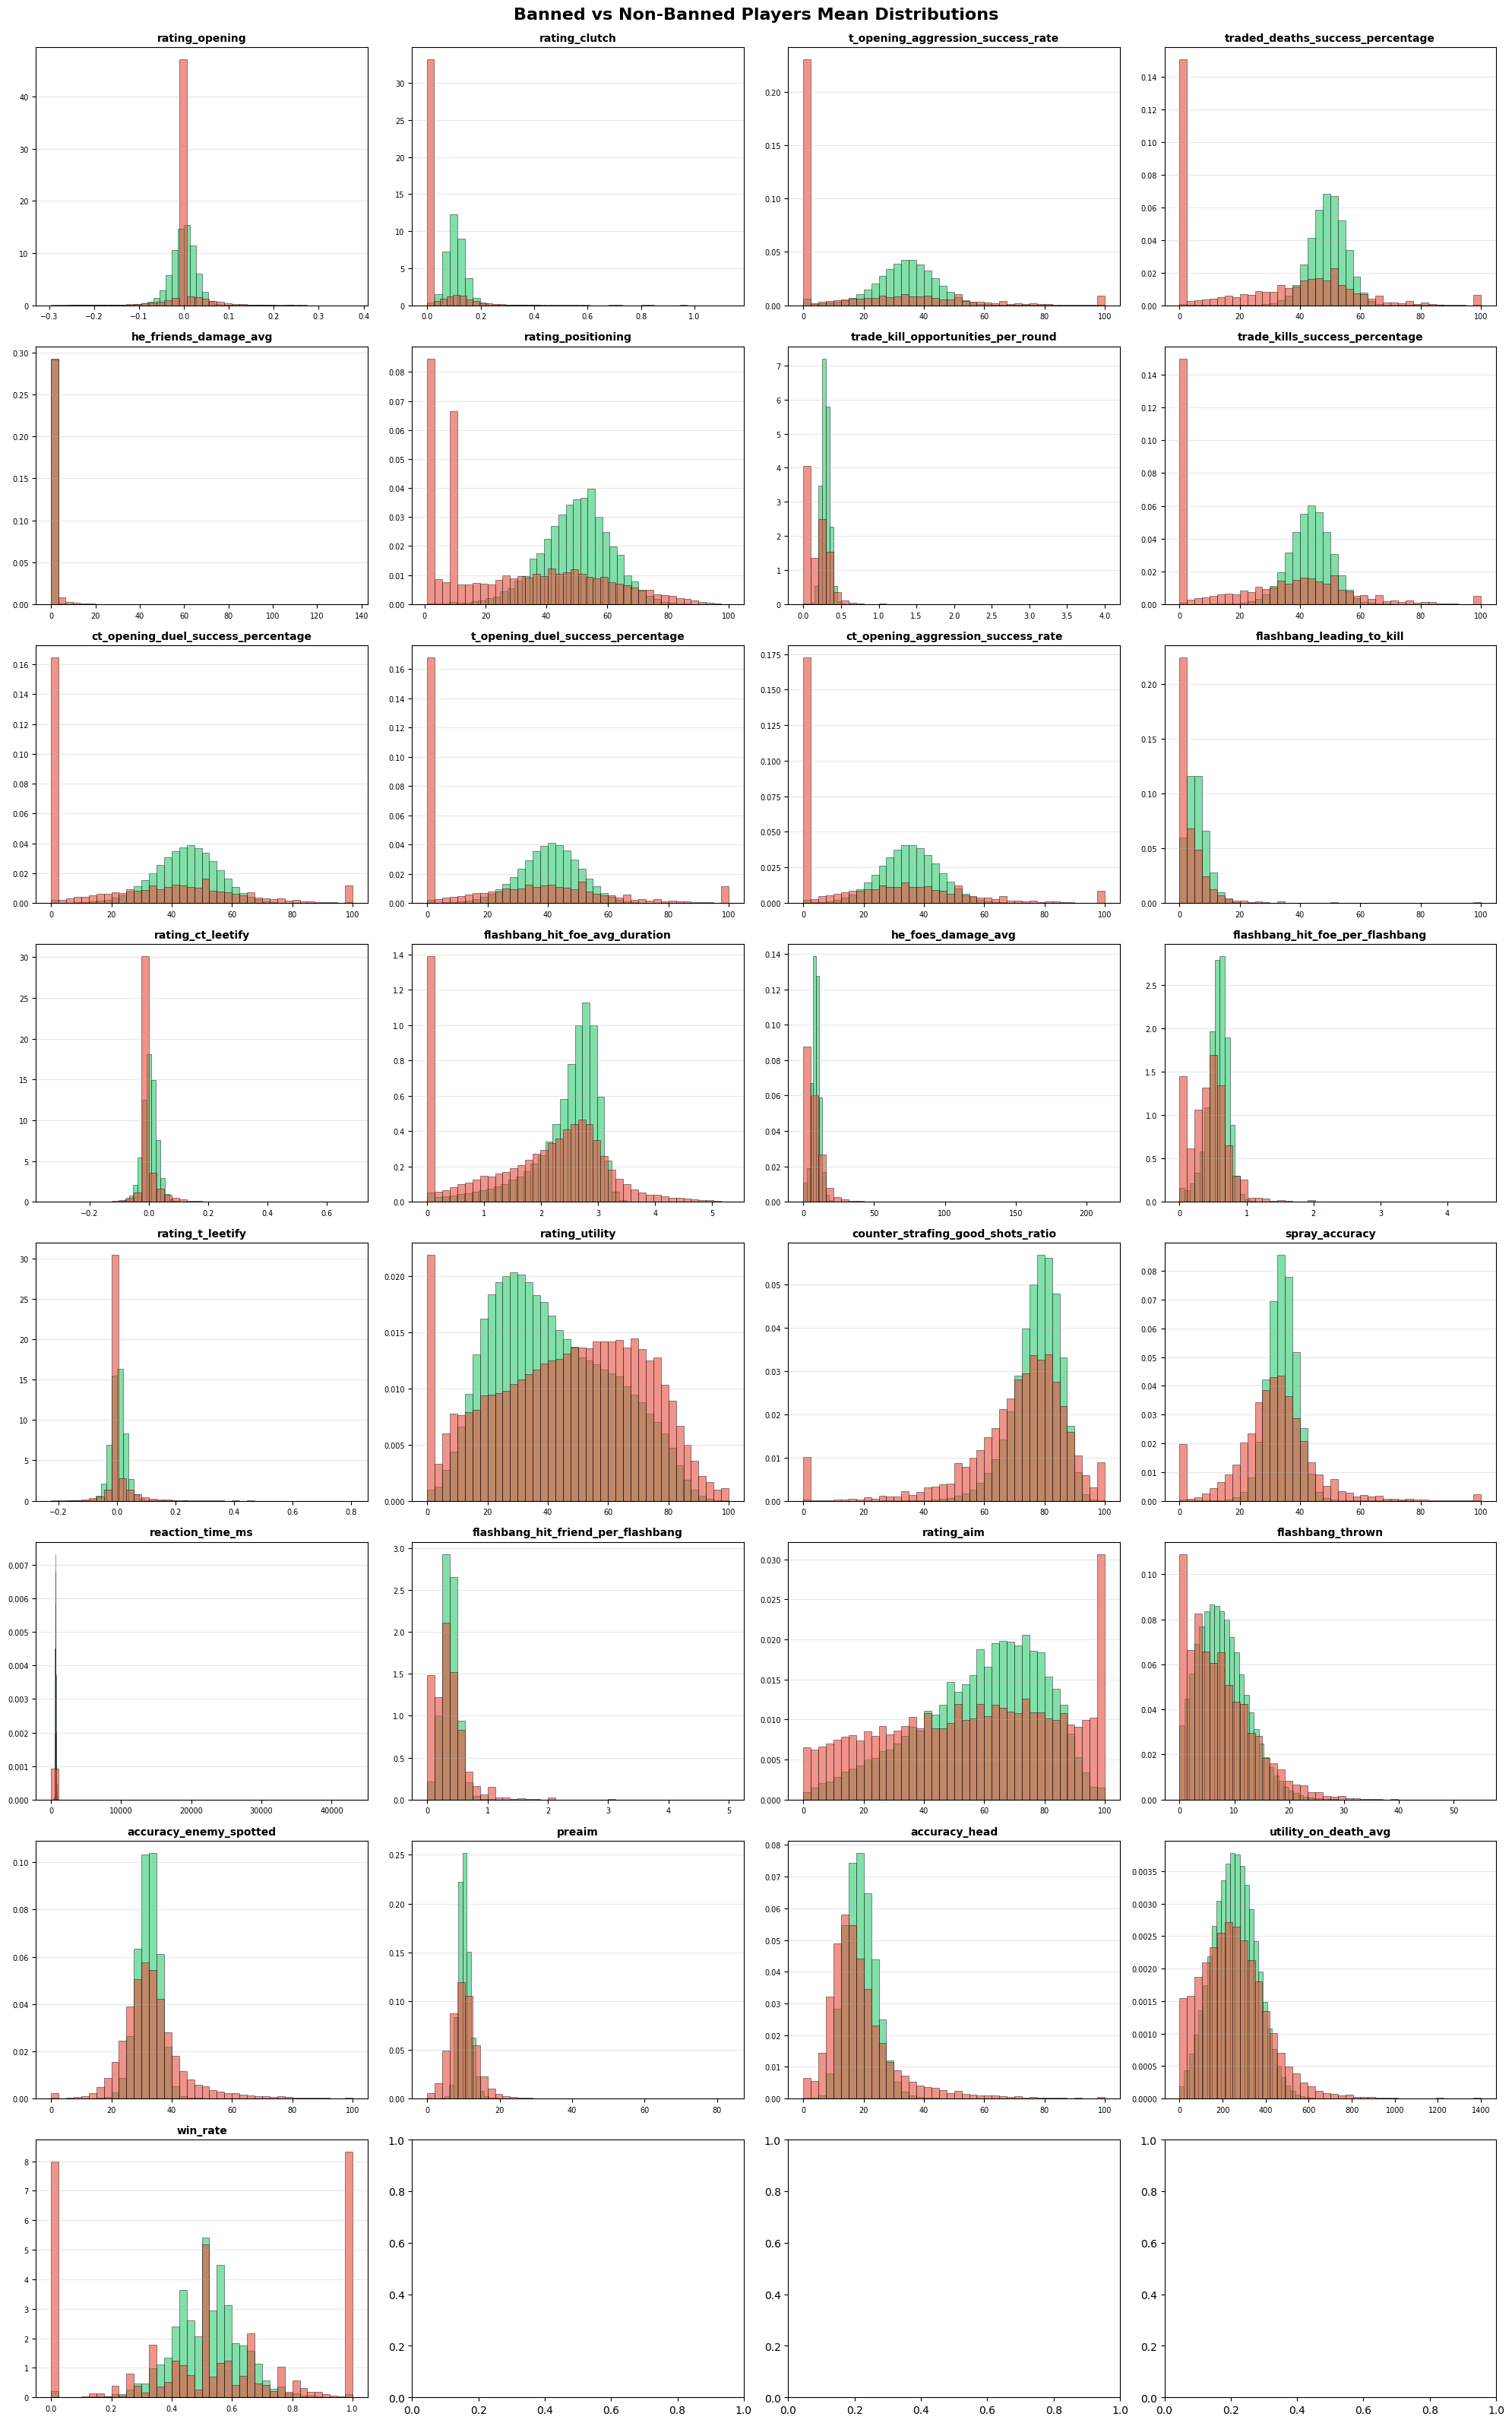

In [11]:
# Distribution plots for all features
features = comparison_df['Feature'].tolist()

n_features = len(features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    
    non_banned_data = df_non_banned[feature].dropna()
    banned_data = df_banned[feature].dropna()
    
    ax.hist(non_banned_data, bins=40, alpha=0.6,  color=COLOUR_NON_BANNED,
            label='Non-Banned', density=True, edgecolor='black', linewidth=0.5)
    ax.hist(banned_data, bins=40, alpha=0.6,  color=COLOUR_BANNED,
            label='Banned', density=True, edgecolor='black', linewidth=0.5)

    ax.set_title(feature, fontsize=10, weight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='both', labelsize=7)

plt.suptitle('Banned vs Non-Banned Players Mean Distributions', fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Results:
Most features do follow the pattern of having an extreme amount of 0 values for banned players. I will now investigate how big of an issue this is more closely

## Zero/Null Value Analysis

In [12]:
features = comparison_df['Feature'].tolist()

zero_analysis = []
for feature in features:
    non_banned_zeros = (df_non_banned[feature] == 0).sum()
    banned_zeros = (df_banned[feature] == 0).sum()
    
    non_banned_zero_pct = (non_banned_zeros / len(df_non_banned)) * 100
    banned_zero_pct = (banned_zeros / len(df_banned)) * 100
    difference = banned_zero_pct - non_banned_zero_pct
    
    zero_analysis.append({
        'Feature': feature,
        'Non-Banned Zero %': non_banned_zero_pct,
        'Banned Zero %': banned_zero_pct,
        'Difference': difference
    })

zero_df = pd.DataFrame(zero_analysis)
zero_df = zero_df.sort_values('Difference', ascending=False)

high_zeros = zero_df[zero_df['Difference'] > 5]  # More than 5% difference
if len(high_zeros) > 0:
    print(high_zeros.to_string(index=False))
else:
    print("No features found")

print(zero_df.to_string(index=False))

                           Feature  Non-Banned Zero %  Banned Zero %  Difference
                     rating_clutch           0.436510      79.139926   78.703416
                    rating_opening           0.355488      76.082437   75.726949
                 rating_ct_leetify           0.339594      68.107656   67.768062
                  rating_t_leetify           0.330678      68.048902   67.718224
 t_opening_aggression_success_rate           1.319610      57.326223   56.006613
             he_friends_damage_avg           3.290496      51.848504   48.558008
         flashbang_leading_to_kill           4.113508      46.919913   42.806405
ct_opening_aggression_success_rate           0.572193      42.856820   42.284627
 t_opening_duel_success_percentage           0.525673      41.833137   41.307464
ct_opening_duel_success_percentage           0.449691      40.967640   40.517949
  traded_deaths_success_percentage           0.177550      37.313568   37.136017
    trade_kills_success_perc

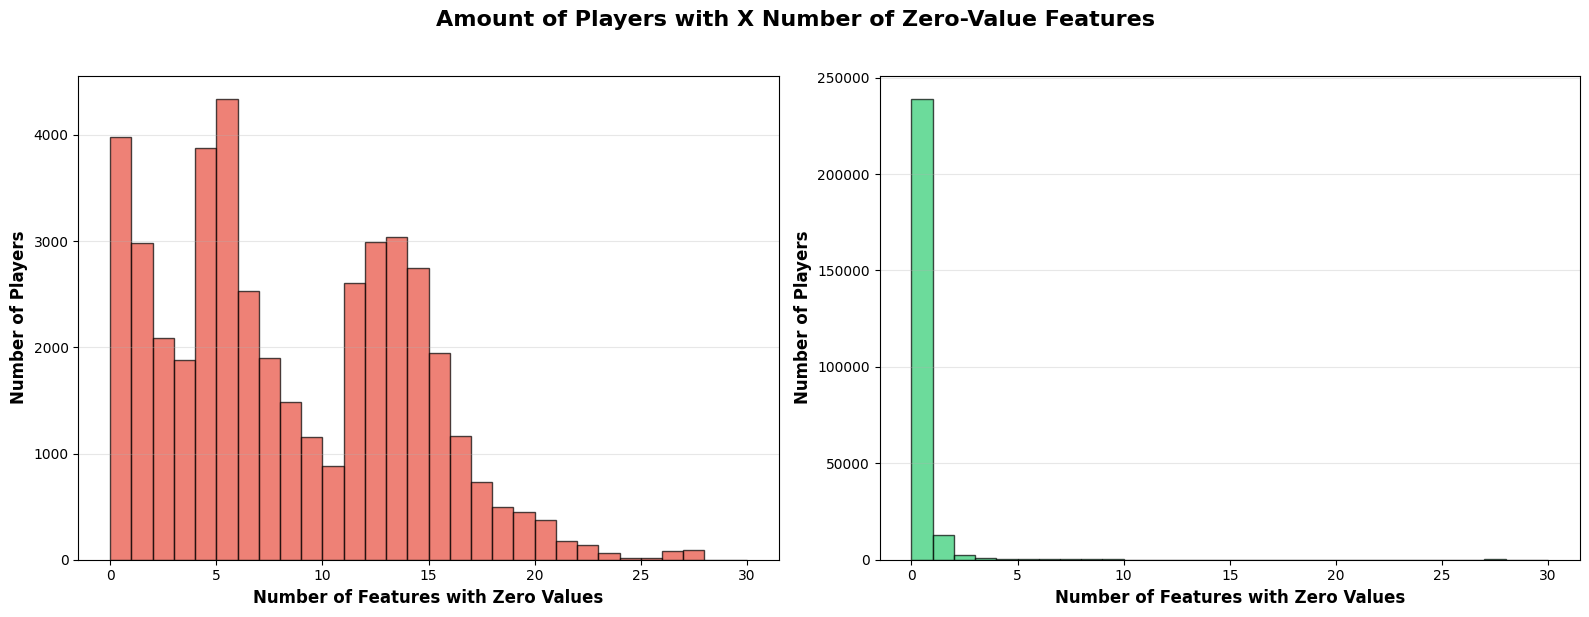

In [13]:
# Count how many zero-value features each player has
features = comparison_df['Feature'].tolist()

banned_zero_counts = (df_banned[features] == 0).sum(axis=1)
non_banned_zero_counts = (df_non_banned[features] == 0).sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
ax1.hist(banned_zero_counts, bins=range(0, len(features) + 2),
          color=COLOUR_BANNED, alpha=0.7, edgecolor='black', linewidth=1)
ax1.set_xlabel('Number of Features with Zero Values', fontsize=12, weight='bold')
ax1.set_ylabel('Number of Players', fontsize=12, weight='bold')
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[1]
ax2.hist(non_banned_zero_counts, bins=range(0, len(features) + 2),
          color=COLOUR_NON_BANNED, alpha=0.7, edgecolor='black', linewidth=1)
ax2.set_xlabel('Number of Features with Zero Values', fontsize=12, weight='bold')
ax2.set_ylabel('Number of Players', fontsize=12, weight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Amount of Players with X Number of Zero-Value Features',
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Results:
A worrying amount of banned players have more than 5 features with zero values, with many having as much as 20 missing features. Non banned players data is generally perfect with very few zero values. This will require significant data cleaning before model training

## Poor Data Quality Theories and Next Steps

### Theory 1: Banned Player Data Expiration
Issue: Banned players show high zero-value counts.

Cause:
- Leetify API only retains player data for 30 days
- Data collection process:
  1. Retrieve Steam IDs of banned players from VAClist
  2. Fetch player profiles from Leetify API
- By the time banned players are fetched from Leetify, their data has often expired or been deleted
- This results in incomplete/missing statistics for banned players

### Theory 2: Zero Values from Actively Developing API
Issue: Banned players show high zero-value counts.

Cause:
- Leetify API has added new features over time
- Players who haven't played recently don't have data for newer features
- Older profiles are missing statistics that didn't exist when they last played

### Potential Resolutions:
1. Filter out players with too few matches
2. Remove entries with excessive zero values
3. 'Guess' missing values based on similar player profiles or use imputation techniques


## Features with High Zero-Value Percentages

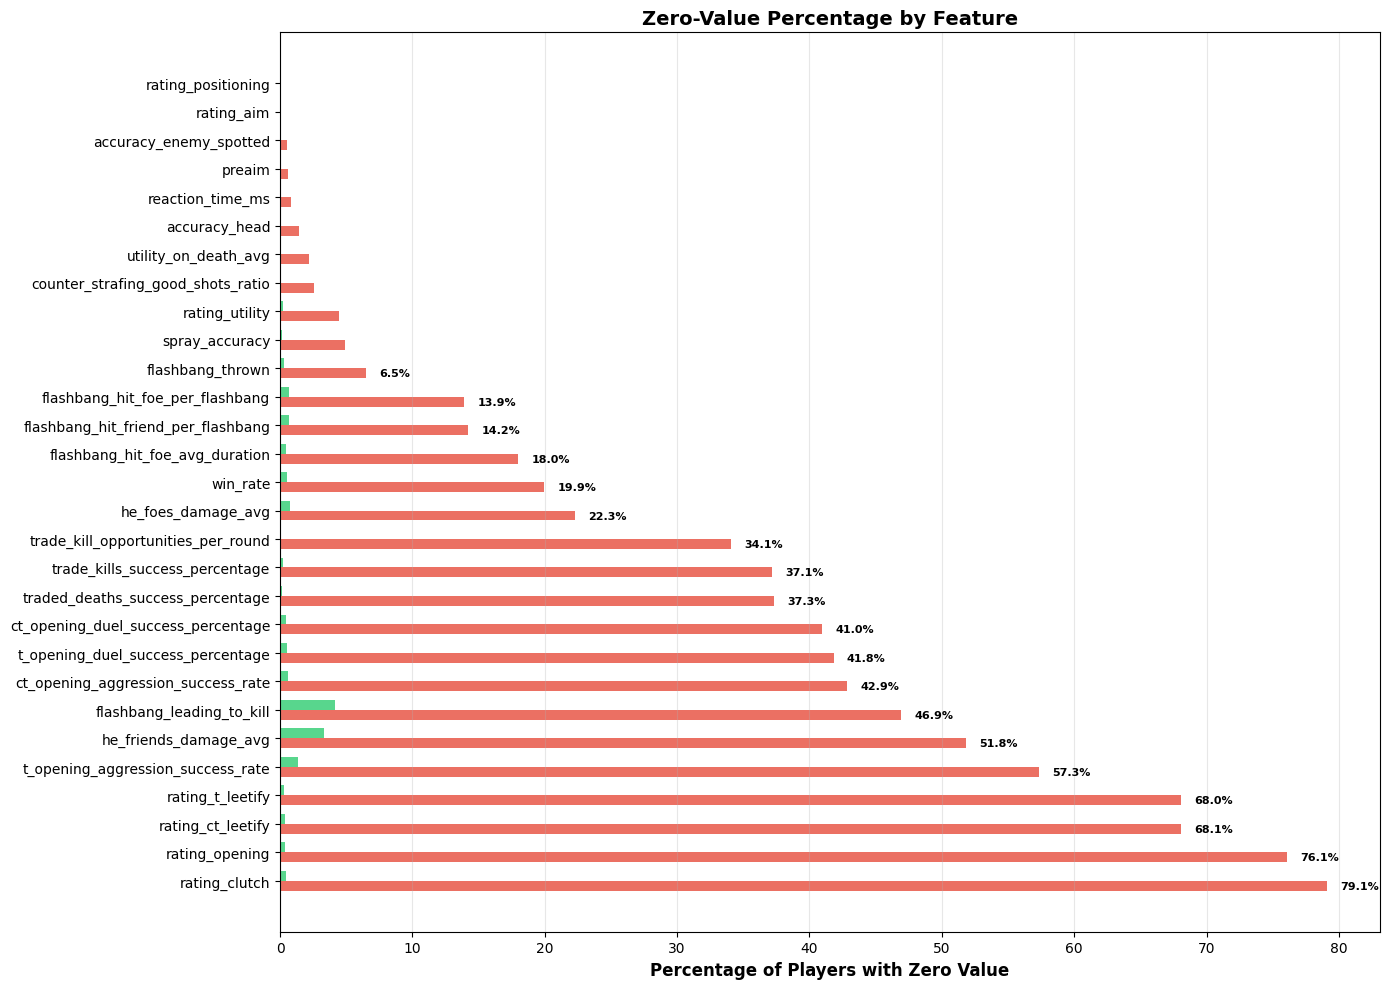

In [14]:
features = comparison_df['Feature'].tolist()

banned_zero_pcts = []
non_banned_zero_pcts = []

for feature in features:
    banned_zeros = (df_banned[feature] == 0).sum()
    non_banned_zeros = (df_non_banned[feature] == 0).sum()

    banned_zero_pcts.append((banned_zeros / len(df_banned)) * 100)
    non_banned_zero_pcts.append((non_banned_zeros / len(df_non_banned)) * 100)

sorted_indices = sorted(range(len(banned_zero_pcts)), key=lambda i: banned_zero_pcts[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_banned_pcts = [banned_zero_pcts[i] for i in sorted_indices]
sorted_non_banned_pcts = [non_banned_zero_pcts[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(14, 10))
y_pos = range(len(sorted_features))
width = 0.35

bars_banned = ax.barh([i - width/2 for i in y_pos], sorted_banned_pcts, width,
                      label='Banned Players',  color=COLOUR_BANNED, alpha=0.8)
bars_non_banned = ax.barh([i + width/2 for i in y_pos], sorted_non_banned_pcts, width,
                          label='Non-Banned Players',  color=COLOUR_NON_BANNED, alpha=0.8)

for i, (banned_pct, non_banned_pct) in enumerate(zip(sorted_banned_pcts, sorted_non_banned_pcts)):
    if banned_pct > 5:
        ax.text(banned_pct + 1, i - width/2, f'{banned_pct:.1f}%',
                va='center', fontsize=8, weight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_features, fontsize=10)
ax.set_xlabel('Percentage of Players with Zero Value', fontsize=12, weight='bold')
ax.set_title('Zero-Value Percentage by Feature',fontsize=14, weight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Results:
Most features have a significant amount of banned players with zero values. A saving grace in this is it seems the newer data features that leetify has added tend to be more niche stats and would have less predictive power than features like rating_aim and reaction_time_ms so we might be able to just simple not use features which have too high of a missing values. Potential missing threshold percentages I might use could be 10% or 25%.

# Conclusion
By exploring the data, I discovered severe issues with my dataset. Our set of banned players have an extremely high amount of zero value features. Had this not been spotted, the model would have not performed well at all. To resolve this, I will need to implement data cleaning steps such as filtering out players with too few matches or too many zero values. Additionally, I may need to impute missing values based on similar player profiles as I still want a sizeable banned player dataset to use.